# At what age did the youth first use a substance?

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

### Data Loading and Cleaning

In [2]:
df = pd.read_csv('youth_data.csv')
columns_with_991_993 = ['IRALCFY', 'IRMJFY', 'IRCIGFM', 
                        'IRSMKLSS30N', 'IRMJFM', 'IRCIGAGE', 
                        'IRSMKLSSTRY', 'IRALCAGE']

for col in columns_with_991_993:
    if col in df.columns:
        df[col] = df[col].replace({994: np.nan, 997: np.nan, 998: np.nan})
        df[col] = df[col].replace({991: np.nan, 993: np.nan})

columns_with_91_93 = ['IRCIGFM', 'IRSMKLSS30N', 'IRMJFM']
for col in columns_with_91_93:
    if col in df.columns:
        df[col] = df[col].replace({91: 0, 93: 0})

# Fix invalid entries for missed school days
if 'EDUSKPCOM' in df.columns:
    df['EDUSKPCOM'] = df['EDUSKPCOM'].replace({94: np.nan, 97: np.nan, 98: np.nan, 99: np.nan})

if 'IMOTHER' in df.columns:
    df = df[df['IMOTHER'] != 4]
    df['IMOTHER'] = df['IMOTHER'].map({1: 1, 2: 0, 3: np.nan})

if 'IFATHER' in df.columns:
    df = df[df['IFATHER'] != 4]
    df['IFATHER'] = df['IFATHER'].map({1: 1, 2: 0, 3: np.nan})

#Remove rows where IRMJAGE is 991 (Never used marijuana)
df = df[df['IRMJAGE'] <= 83]

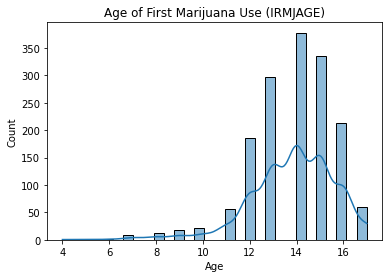

In [21]:
sns.histplot(x='IRMJAGE', data=df, bins=30, kde=True)
plt.title('Age of First Marijuana Use (IRMJAGE)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('IRMJAGE_distribution.png', bbox_inches='tight', dpi=300)
plt.show()

### Feature Engineering

In [3]:
#Define Features and Target
demographic_features = ['IRSEX', 'NEWRACE2', 'INCOME', 'POVERTY3', 'PDEN10', 'COUTYP4', 'HEALTH2']
school_features = ['EDUSCHLGO', 'EDUSCHGRD2', 'EDUSKPCOM']
parental_features = ['IMOTHER', 'IFATHER', 'PARCHKHW', 'PARHLPHW', 'PRCHORE2', 
                     'PRLMTTV2', 'PARLMTSN', 'PRGDJOB2', 'PRPROUD2', 'ARGUPAR']

all_features = demographic_features + school_features + parental_features
target = 'IRMJAGE'

df_clean = df.dropna(subset=all_features + [target])

# Impute remaining missing feature values with mean
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(df_clean[all_features]), columns=all_features)
y = df_clean[target]

feature_rename_map = {
    'IRSEX': 'Gender',
    'NEWRACE2': 'Race/Ethnicity',
    'INCOME': 'Family Income',
    'POVERTY3': 'Poverty Level',
    'PDEN10': 'Population Density',
    'COUTYP4': 'County Type',
    'HEALTH2': 'Health Rating',
    'EDUSCHLGO': 'Currently in School',
    'EDUSCHGRD2': 'School Grade',
    'EDUSKPCOM': 'Missed School Days (Sick)',
    'IMOTHER': 'Mother in Household',
    'IFATHER': 'Father in Household',
    'PARCHKHW': 'Parent Checks Homework',
    'PARHLPHW': 'Parent Helps Homework',
    'PRCHORE2': 'Parent Assigns Chores',
    'PRLMTTV2': 'Limits on TV Time',
    'PARLMTSN': 'Limits on Going Out',
    'PRGDJOB2': 'Parental Praise (Job)',
    'PRPROUD2': 'Parental Pride',
    'ARGUPAR': 'Family Arguments'
}
X.rename(columns=feature_rename_map, inplace=True)
print("Final cleaned dataset shape:", X.shape)

Final cleaned dataset shape: (1079, 20)


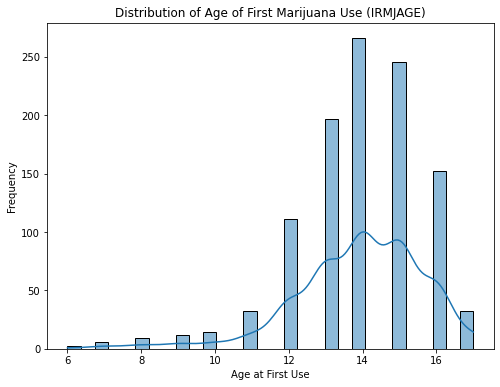

IRMJAGE Summary Statistics:
count    1079.000000
mean       13.910102
std         1.758172
min         6.000000
25%        13.000000
50%        14.000000
75%        15.000000
max        17.000000
Name: IRMJAGE, dtype: float64


In [6]:
plt.figure(figsize=(8,6))
sns.histplot(y, bins=30, kde=True)
plt.title('Distribution of Age of First Marijuana Use (IRMJAGE)')
plt.xlabel('Age at First Use')
plt.ylabel('Frequency')
plt.show()

print("IRMJAGE Summary Statistics:")
print(y.describe())

### Decision Tree Classifier (Unpruned)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

#training set
print("\nClass distribution in Training set:")
print(y_train.value_counts(normalize=True) * 100)

#test set
print("\nClass distribution in Test set:")
print(y_test.value_counts(normalize=True) * 100)

Training set shape: (755, 20)
Test set shape: (324, 20)

Class distribution in Training set:
IRMJAGE
14    24.635762
15    22.781457
13    18.278146
16    14.039735
12    10.331126
11     2.913907
17     2.913907
10     1.324503
9      1.192053
8      0.794702
7      0.529801
6      0.264901
Name: proportion, dtype: float64

Class distribution in Test set:
IRMJAGE
14    24.691358
15    22.839506
13    18.209877
16    14.197531
12    10.185185
11     3.086420
17     3.086420
10     1.234568
9      0.925926
8      0.925926
7      0.617284
Name: proportion, dtype: float64


In [9]:
tree_regressor = DecisionTreeRegressor(random_state=42)
tree_regressor.fit(X_train, y_train)

y_pred_tree = tree_regressor.predict(X_test)

mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)

print(f"Decision Tree Regressor Performance:")
print(f" - RMSE: {rmse_tree:.4f}")
print(f" - MAE: {mae_tree:.4f}")
print(f" - MSE: {mse_tree:.4f}")

Decision Tree Regressor Performance:
 - RMSE: 2.0443
 - MAE: 1.5062
 - MSE: 4.1790



Decision Tree Info:
 - Total Nodes in Tree: 1003
 - Total Leaves in Tree: 502
 - Max Depth of Tree: 18


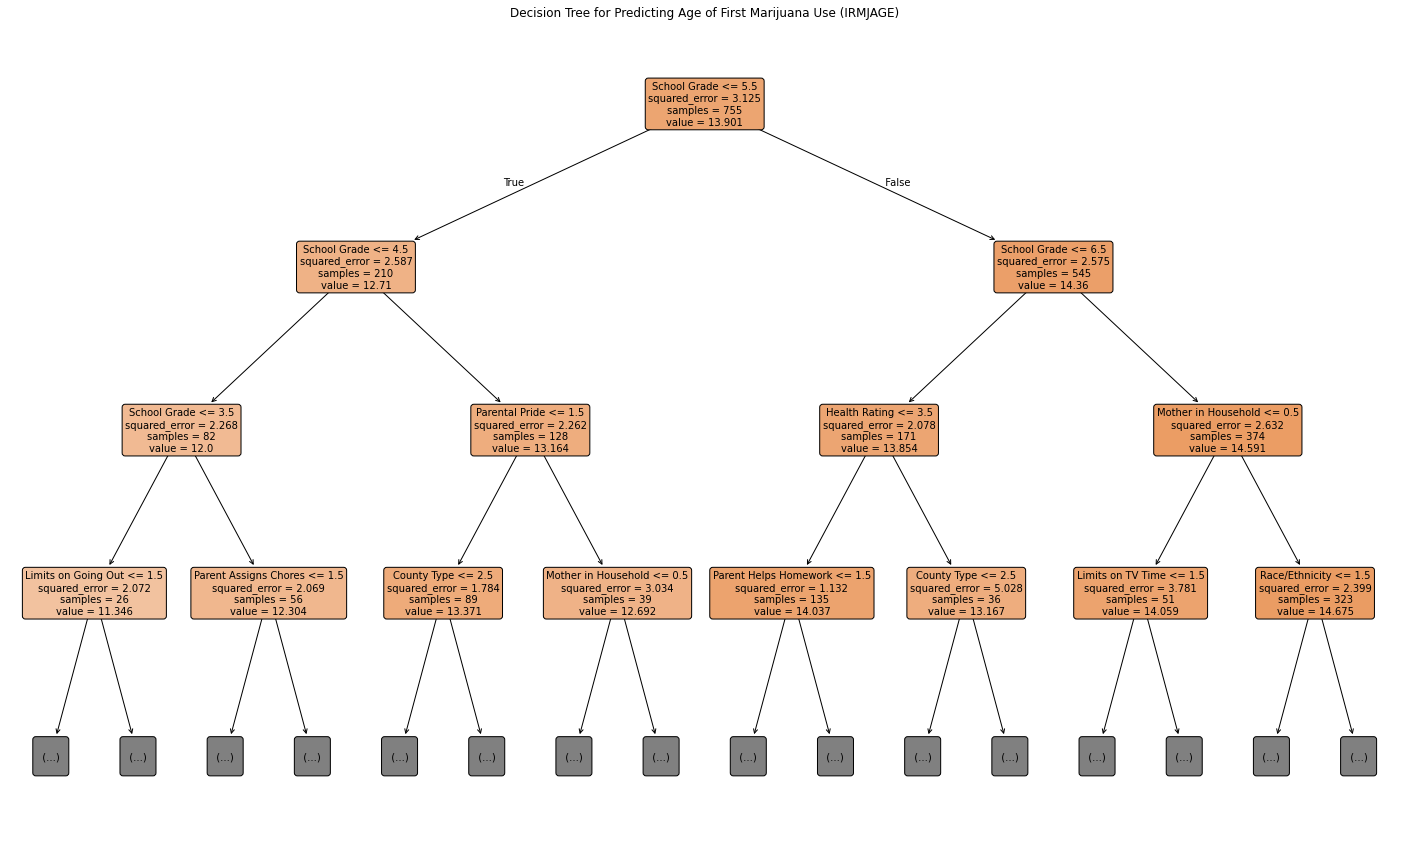

In [12]:
from sklearn.tree import plot_tree

print("\nDecision Tree Info:")
print(f" - Total Nodes in Tree: {tree_regressor.tree_.node_count}")
print(f" - Total Leaves in Tree: {tree_regressor.get_n_leaves()}")
print(f" - Max Depth of Tree: {tree_regressor.get_depth()}")

plt.figure(figsize=(25, 15))
plot_tree(
    tree_regressor,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth = 3
)
plt.title("Decision Tree for Predicting Age of First Marijuana Use (IRMJAGE)")
plt.show()

### Random Forest

In [15]:
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
rf_regressor.fit(X_train, y_train)

y_pred_rf = rf_regressor.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest Regressor Performance:")
print(f" - RMSE: {rmse_rf:.4f}")
print(f" - MAE: {mae_rf:.4f}")
print(f" - MSE: {mse_rf:.4f}")

Random Forest Regressor Performance:
 - RMSE: 1.5362
 - MAE: 1.1493
 - MSE: 2.3598


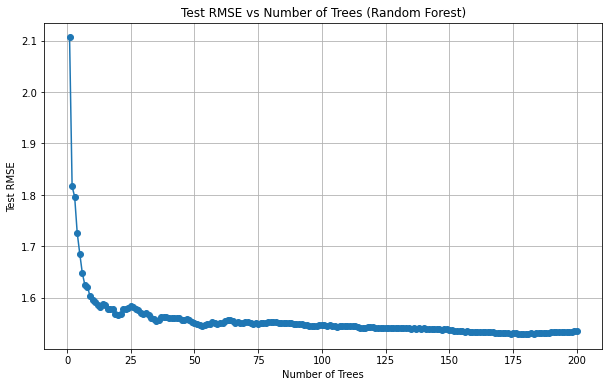

In [16]:
rf_error_plot = RandomForestRegressor(n_estimators=1, warm_start=True, random_state=42)

errors = []
n_trees_range = range(1, 201)  

for n in n_trees_range:
    rf_error_plot.set_params(n_estimators=n)
    rf_error_plot.fit(X_train, y_train)
    y_pred = rf_error_plot.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    errors.append(rmse)

# Plot
plt.figure(figsize=(10,6))
plt.plot(n_trees_range, errors, marker='o')
plt.title('Test RMSE vs Number of Trees (Random Forest)')
plt.xlabel('Number of Trees')
plt.ylabel('Test RMSE')
plt.grid(True)
plt.show()

In [17]:
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [100, 200, 300] 
}

grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,  
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    verbose=2
)

grid_search_rf.fit(X_train, y_train)
best_rf_regressor = grid_search_rf.best_estimator_

y_pred_best_rf = best_rf_regressor.predict(X_test)

mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mse_best_rf)
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)

print(f"Best Random Forest Regressor Performance:")
print(f" - RMSE: {rmse_best_rf:.4f}")
print(f" - MAE: {mae_best_rf:.4f}")
print(f" - MSE: {mse_best_rf:.4f}")
print("\nBest Hyperparameters Found:")
print(grid_search_rf.best_params_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Random Forest Regressor Performance:
 - RMSE: 1.5352
 - MAE: 1.1382
 - MSE: 2.3568

Best Hyperparameters Found:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}


## Gradient Boosting Regressor

In [18]:
#learning rate (shrinkage)
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]  # Typical depth for boosting
}

grid_search_gbr = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_gbr,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search_gbr.fit(X_train, y_train)
best_gbr = grid_search_gbr.best_estimator_

y_pred_gbr = best_gbr.predict(X_test)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)

print(f"Gradient Boosting Regressor Performance (Tuned):")
print(f" - RMSE: {rmse_gbr:.4f}")
print(f" - MAE: {mae_gbr:.4f}")
print(f" - MSE: {mse_gbr:.4f}")
print("\nBest Hyperparameters Found for Gradient Boosting:")
print(grid_search_gbr.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Gradient Boosting Regressor Performance (Tuned):
 - RMSE: 1.4745
 - MAE: 1.1029
 - MSE: 2.1743

Best Hyperparameters Found for Gradient Boosting:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


### Conclusion

The Tuned Gradient Boosting Regressor achieved the best performance, with an RMSE of 1.4745 years and MAE of 1.1029 years in predicting the age of first marijuana use.

Random Forest Regressor with hyperparameter tuning (max_depth=10, max_features=sqrt, n_estimators=200) also performed well with an RMSE of 1.5352.

Default Random Forest and Decision Tree models showed higher errors compared to tuned models.

Hyperparameter tuning, especially depth control and feature selection, significantly improved Random Forest performance.

Shrinkage tuning (learning rate=0.01) in Gradient Boosting helped reduce overfitting and stabilized generalization performance.

The Error vs Number of Trees plot for Random Forest showed rapid error drop initially, then stabilization after about 100–150 trees.
